<a href="https://colab.research.google.com/github/Sagar401/FAI/blob/features/Assignment_3_Street_View_House_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [0]:
%matplotlib inline
!pip install openml # Uncomment to run in Google Colab
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time

In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [3]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "wb") as f:
    pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
    pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# (Uncomment to) Load SVHN dataset from Google drive
# from google.colab import drive
# drive.mount('/content/drive')

# with open("drive/My Drive/SVHN.pkl", "rb") as f:
#     X = pickle.load(f)
#     y = pickle.load(f)
#     cats = pickle.load(f)
#     attrs = pickle.load(f)

### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [4]:
X.shape

(99289, 3072)

In [15]:
32*32*3

3072

In [17]:
type(X)

numpy.ndarray

### You can use the following function to plot the first 10 images to get a sense of the data.

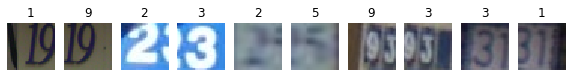

In [42]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

In [0]:
def rgb_to_grayscale(X):
  rgb_weights = [0.2989, 0.5870, 0.1140]
  grayscale_img = np.expand_dims(np.dot((X.reshape(len(X),32*32,3)/255 ),rgb_weights),axis=3)
  return grayscale_img


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


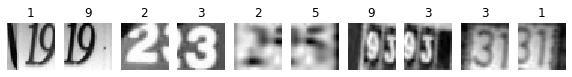

In [98]:
X_gray = rgb_to_grayscale(X)
plot_images(X_gray[0:10],y[0:10],True)

In [0]:
y = y +1

In [0]:
y = np.where(y == 10,0,y)

In [180]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

In [0]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

X_sample, _ , y_sample, _ = train_test_split(X_gray,y,stratify = y,train_size = 0.03)

In [0]:
def evaluate_learners(classifiers, X, y):
  """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data. 

  Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
    - a list with the scores obtained on the training samples for each classifier,
    - a list with the test scores obtained on the test samples for each classifier.
    The order of scores should match the order in which the classifiers were originally provided. E.g.:     
    [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
  """
  results = [cross_validate(model,X,y, return_train_score=True,cv=3) for model in classifiers]
  test_scores = [r['test_score'] for r in results]
  train_scores = [r['train_score'] for r in results]
  return train_scores, test_scores


In [106]:
classifiers = [LogisticRegression(),LinearSVC(),KNeighborsClassifier()]
classifiers = np.array([c for c in classifiers]).flatten()

train_scores, test_scores = evaluate_learners(classifiers,X_sample.reshape(len(X_sample),32*32),y_sample)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [107]:
train_scores

[array([0.34811083, 0.35869018, 0.34642497]),
 array([0.5324937 , 0.52695214, 0.50302115]),
 array([0.54206549, 0.5395466 , 0.54028197])]

In [108]:
test_scores

[array([0.19939577, 0.21047331, 0.22479839]),
 array([0.17724068, 0.1510574 , 0.19556452]),
 array([0.32628399, 0.32729104, 0.3296371 ])]

In [102]:
train_scores

[array([0.54009077, 0.53101362, 0.53172205]),
 array([0.76550681, 0.77609682, 0.78247734]),
 array([0.48411498, 0.47049924, 0.47280967])]

In [103]:
test_scores

[array([0.17824773, 0.20543807, 0.2       ]),
 array([0.19335347, 0.18429003, 0.17272727]),
 array([0.27794562, 0.28096677, 0.24242424])]

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9,10],rotation=90)
  plt.yticks([])
  thisplot = plt.bar([0,1,2,3,4,5,6,7,8,9,10], predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [109]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [111]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.1.0


In [0]:

X_train, X_test , y_train, y_test = train_test_split(X_gray.reshape(len(X_gray),32,32),y,stratify = y,train_size = 0.8)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,32)),
    keras.layers.Dense(256,activation = 'relu'),
    keras.layers.Dense(11)
])


In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [184]:
model.fit(X_train, y_train, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 10s 128us/sample - loss: 2.0032 - accuracy: 0.2965
Epoch 2/10
79431/79431 [==============================] - 10s 126us/sample - loss: 1.4922 - accuracy: 0.5096
Epoch 3/10
79431/79431 [==============================] - 10s 123us/sample - loss: 1.3574 - accuracy: 0.5698
Epoch 4/10
79431/79431 [==============================] - 10s 126us/sample - loss: 1.3007 - accuracy: 0.5937
Epoch 5/10
79431/79431 [==============================] - 10s 126us/sample - loss: 1.2700 - accuracy: 0.6049
Epoch 6/10
79431/79431 [==============================] - 10s 126us/sample - loss: 1.2479 - accuracy: 0.6142
Epoch 7/10
79431/79431 [==============================] - 10s 124us/sample - loss: 1.2282 - accuracy: 0.6221
Epoch 8/10
79431/79431 [==============================] - 10s 128us/sample - loss: 1.2040 - accuracy: 0.6349
Epoch 9/10
79431/79431 [==============================] - 10s 124us/sample - loss: 1.1792 - accuracy: 0.6

In [185]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

19858/19858 - 2s - loss: 1.1502 - accuracy: 0.6593

Test accuracy: 0.65933126


In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
class_predictions = model.predict_classes(X_test)
prediction_probabilities = probability_model.predict(X_test)

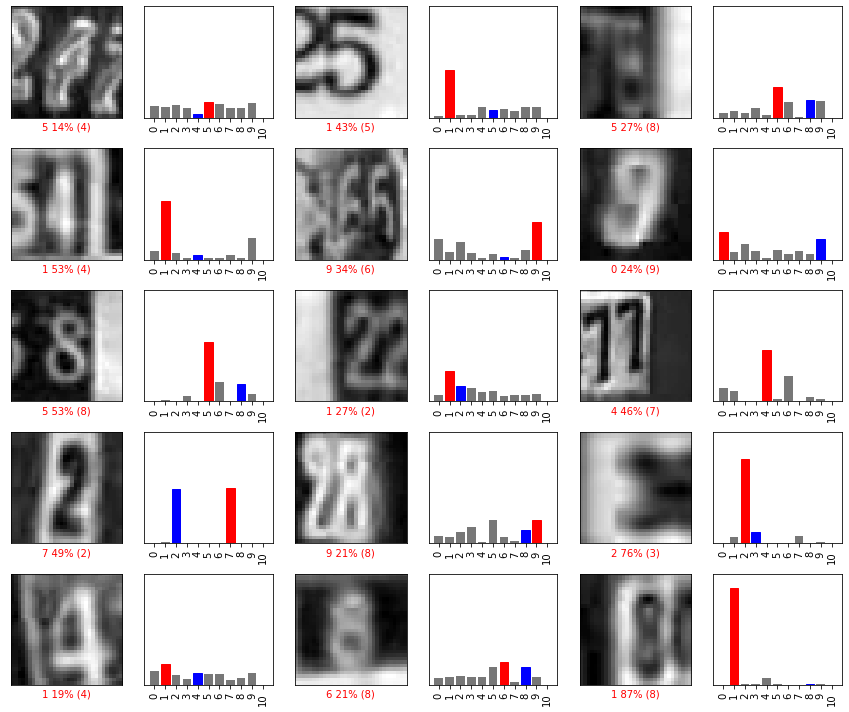

In [209]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
misclassified = np.where(class_predictions != y_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,j in zip(misclassified[0], range(num_images)):
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, prediction_probabilities[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, prediction_probabilities[i], y_test)
plt.tight_layout()
plt.show()

In [0]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=class_predictions).numpy()

In [211]:
con_mat

array([[ 899,   91,   47,   37,   37,   38,   92,   45,    6,   46],
       [  79, 3226,  108,   73,  113,   54,   29,   69,    9,   32],
       [  90,  244, 2037,  101,   60,   37,   60,  231,   14,   73],
       [  80,  262,  154, 1337,   39,  241,   34,   75,   16,   38],
       [  68,  290,   53,   26, 1346,   56,  112,   17,    9,   19],
       [  66,  126,   42,  177,   47, 1155,  117,   27,   29,   67],
       [ 114,  105,   32,   35,   96,   98,  967,   21,   43,   30],
       [  71,  156,  140,   38,   21,   18,   12, 1041,    5,   21],
       [  93,  137,   58,   45,   57,  187,  236,   17,  410,  101],
       [ 177,  110,   51,   45,   21,   80,   45,   33,   14,  675]],
      dtype=int32)

In [190]:
print("Number of Categories: ",len(np.unique(y_train)))

Number of Categories:  10


Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 